In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['figure.dpi'] = 450

In [3]:
root_dir = '/Volumes/Data2/RST/notebook/'
data_dir = '/Volumes/Data2/RST/notebook/networks/'

In [4]:
# data_dir = 'D:\\RST\\notebook\\networks\\'
# root_dir = 'D:\\RST\\notebook\\'

In [5]:
directory = pd.read_csv(root_dir + 'GIS/int_directory.csv')

# Sample Iteration for `raw_am`

In [6]:
period = 'AM'

In [7]:
bc_avg = pd.read_csv(data_dir + period + '/' + 'BC-' + period + '_node-avg.csv' )

In [8]:
bc_avg['o_node'] = bc_avg['o_node'] - 1000
bc_avg['d_node'] = bc_avg['d_node'] - 1000

In [9]:
tts = pd.read_csv(root_dir + 'TTS OD/TTS_TYPE.csv')
tts = tts.rename(columns = {'origin':'o_node', 'destination':'d_node'})

In [10]:
tts_pivot = tts
tts_pivot = tts_pivot.groupby('type').agg({'total':'sum'}).reset_index()
tts_pivot['group'] = tts_pivot['type'].str.split('_', expand = True)[0]
tts_pivot['period'] = tts_pivot['type'].str.split('_', expand = True)[1]

In [13]:
np.round(tts_pivot.pivot('group', 'period', 'total').astype(int))

period,am,em,ev,md,pm
group,,,,,
ab,345,8,82,107,366
bl,18536,577,3783,5589,15952
c0,62089,2317,21377,29944,71600
imm,15436,362,3177,4381,14558
lep,9683,244,1976,2812,8969
lico,59928,2186,15890,27395,51070
rac,105997,2702,21821,30357,98770
raw,211847,4735,44598,62700,204353


In [14]:
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [12]:
period_tts = tts[tts['type'] == 'raw_' + period.lower()]
period_tts

,o_node,d_node,type,total
0,1,18,raw_am,15.000
1,1,35,raw_am,14.000
2,1,57,raw_am,20.000
3,1,68,raw_am,14.000
4,1,212,raw_am,8.000
...,...,...,...,...
23930,624,74,raw_am,8.000
23931,624,371,raw_am,20.000
23933,624,391,raw_am,22.000
23935,624,493,raw_am,44.000


In [13]:
stop_times_od = pd.read_csv(root_dir + 'networks/' + period + '-TE-16.csv')
N = len((stop_times_od['INT_ID_o'].append(stop_times_od['INT_ID_d'])).drop_duplicates())
N

3528

In [14]:
bc_all = bc_avg.merge(period_tts)
bc_od = bc_all.copy()
bc_all['weighted'] = (bc_all['bc_single'] * bc_all['total'] * 1000000000)

bc_all = bc_all.groupby('INT_ID').agg({'weighted':'sum'}).reset_index()
bc_all['weighted'] = bc_all['weighted']/((N - 1) * (N - 2) * period_tts['total'].sum())

In [15]:
bc_all = bc_all.merge(directory, how = 'inner')

In [16]:
bc_all['quantile'] = pd.qcut(bc_all['weighted'], 100, labels=False)
bc_all.sort_values(by = 'weighted', ascending = False).head(10)

,INT_ID,weighted,string,quantile
6,106,28.361,Bloor-Yonge Station,99
22,156,21.529,St George Station,99
4,104,16.997,College Station,99
5,105,16.867,Wellesley Station,99
9,109,14.571,St Clair Station,99
8,108,14.089,Summerhill Station,99
48,216,14.086,Sherbourne Station,99
11,111,14.054,Eglinton Station,99
7,107,13.908,Rosedale Station,99
50,218,13.590,Broadview Station,99


In [18]:
pd.qcut(bc_all['weighted'], 100).drop_duplicates().sort_values()

173    (-0.00099043, 0.00118]
97          (0.00118, 0.0021]
78           (0.0021, 0.0034]
79          (0.0034, 0.00493]
75          (0.00493, 0.0063]
                ...          
65             (1.119, 1.264]
326            (1.264, 1.511]
63             (1.511, 2.256]
0              (2.256, 9.992]
2             (9.992, 28.361]
Name: weighted, Length: 100, dtype: category
Categories (100, interval[float64]): [(-0.00099043, 0.00118] < (0.00118, 0.0021] < (0.0021, 0.0034] < (0.0034, 0.00493] ... (1.264, 1.511] < (1.511, 2.256] < (2.256, 9.992] < (9.992, 28.361]]

In [19]:
all_period_tts =  tts[tts['type'] == 'raw_' + period.lower()]
all_period = bc_avg.merge(all_period_tts)
all_period['flow'] = all_period['total'] * all_period['bc_single']

In [20]:
all_period = all_period.merge(bc_all[['INT_ID', 'quantile']])

In [21]:
all_sort = all_period.sort_values(by = ['flow'], ascending = False).drop_duplicates(
    subset = ['o_node', 'd_node', 'quantile'], keep = 'first')
all_sort = all_sort.sort_values(by = ['o_node', 'd_node', 'quantile'], ascending = False).reset_index().drop(columns = ['index'])
all_sort['flow_experienced'] = np.nan
all_sort.head(10)

,o_node,d_node,INT_ID,bc_single,type,total,flow,quantile,flow_experienced
0,624,525,228,0.833,raw_am,44.000,36.667,98,nan
1,624,525,303,0.154,raw_am,44.000,6.769,97,nan
2,624,525,13447347,0.679,raw_am,44.000,29.897,96,nan
3,624,525,13447596,0.679,raw_am,44.000,29.897,95,nan
4,624,525,13445746,0.167,raw_am,44.000,7.333,93,nan
5,624,525,13452869,0.756,raw_am,44.000,33.282,91,nan
6,624,525,13445476,0.167,raw_am,44.000,7.333,90,nan
7,624,525,13445219,0.167,raw_am,44.000,7.333,89,nan
8,624,525,13444901,0.167,raw_am,44.000,7.333,88,nan
9,624,525,13445553,0.154,raw_am,44.000,6.769,87,nan


In [19]:
for index, row in all_sort.iterrows():
    if index == 0:
        total = row['total']
        all_sort.at[index, 'flow_experienced'] = row['flow']
        od_sum = 0 + row['flow']
        prev_o = row['o_node']
        prev_d = row['d_node']
    elif (row['o_node'] == prev_o and row['d_node'] == prev_d):
        od_sum = od_sum + row['flow']
        if od_sum < total:
            all_sort.at[index, 'flow_experienced'] = row['flow']
        else:
            if row['total'] - (od_sum - row['flow']) < 0:
                all_sort.at[index, 'flow_experienced'] = 0
            else:
                all_sort.at[index, 'flow_experienced'] = row['total'] - (od_sum - row['flow'])
            
    elif (row['o_node'] != prev_o or row['d_node'] != prev_d):
        total = row['total']
        all_sort.at[index, 'flow_experienced'] = row['flow']
        od_sum = 0 + row['flow']
        prev_o = row['o_node']
        prev_d = row['d_node']
    else:
        print('error', index)
        break

In [20]:
quantile_table = all_sort.groupby('quantile').agg({'flow_experienced':'sum'}).reset_index()
quantile_table['type'] = 'raw_' + period.lower()
quantile_table['perc'] = quantile_table['flow_experienced']*100/quantile_table['flow_experienced'].sum()
quantile_table

,quantile,flow_experienced,type,perc
0,0,28.258,raw_am,0.013
1,1,80.278,raw_am,0.038
2,2,245.048,raw_am,0.116
3,3,104.667,raw_am,0.049
4,4,106.811,raw_am,0.051
5,5,142.807,raw_am,0.068
6,6,311.927,raw_am,0.147
7,7,230.410,raw_am,0.109
8,8,175.027,raw_am,0.083
9,9,546.576,raw_am,0.258


In [21]:
lico_period_tts =  tts[tts['type'] == 'lico_' + period.lower()]
lico_period = bc_avg.merge(lico_period_tts)
lico_period['flow'] = lico_period['total'] * lico_period['bc_single']

In [22]:
lico_period = lico_period.merge(bc_all[['INT_ID', 'quantile']])
lico_sort = lico_period.sort_values(by = ['flow'], ascending = False).drop_duplicates(
    subset = ['o_node', 'd_node', 'quantile'], keep = 'first')
lico_sort = lico_sort.sort_values(by = ['o_node', 'd_node', 'quantile'], ascending = False).reset_index().drop(columns = ['index'])
lico_sort['flow_experienced'] = np.nan

In [23]:
for index, row in lico_sort.iterrows():
    if index == 0:
        total = row['total']
        lico_sort.at[index, 'flow_experienced'] = row['flow']
        od_sum = 0 + row['flow']
        prev_o = row['o_node']
        prev_d = row['d_node']
    elif (row['o_node'] == prev_o and row['d_node'] == prev_d):
        od_sum = od_sum + row['flow']
        if od_sum < total:
            lico_sort.at[index, 'flow_experienced'] = row['flow']
        else:
            if row['total'] - (od_sum - row['flow']) < 0:
                lico_sort.at[index, 'flow_experienced'] = 0
            else:
                lico_sort.at[index, 'flow_experienced'] = row['total'] - (od_sum - row['flow'])
            
    elif (row['o_node'] != prev_o or row['d_node'] != prev_d):
        total = row['total']
        lico_sort.at[index, 'flow_experienced'] = row['flow']
        od_sum = 0 + row['flow']
        prev_o = row['o_node']
        prev_d = row['d_node']
    else:
        print('error', index)
        break

In [24]:
temp_table = lico_sort.groupby('quantile').agg({'flow_experienced':'sum'}).reset_index()
temp_table['type'] = 'lico_' + period.lower()
temp_table['perc'] = temp_table['flow_experienced']*100/temp_table['flow_experienced'].sum()
temp_table

,quantile,flow_experienced,type,perc
0,0,0.000,lico_am,0.000
1,1,27.500,lico_am,0.046
2,2,153.661,lico_am,0.257
3,3,13.250,lico_am,0.022
4,4,7.750,lico_am,0.013
5,5,35.921,lico_am,0.060
6,6,124.428,lico_am,0.208
7,7,126.972,lico_am,0.213
8,8,75.977,lico_am,0.127
9,9,215.441,lico_am,0.361


In [25]:
quantile_table = quantile_table.append(temp_table)

In [31]:
quantile_list = []

for period in ['AM', 'MD', 'PM', 'EV', 'EM']:

    bc_avg = pd.read_csv(data_dir + period + '/' + 'BC-' + period + '_node-avg.csv' )

    bc_avg['o_node'] = bc_avg['o_node'] - 1000
    bc_avg['d_node'] = bc_avg['d_node'] - 1000

    period_tts = tts[tts['type'] == 'raw_' + period.lower()]

    bc_all = bc_avg.merge(period_tts)
    bc_od = bc_all.copy()
    bc_all['weighted'] = (bc_all['bc_single'] * bc_all['total'] * 1000000000)

    bc_all = bc_all.groupby('INT_ID').agg({'weighted':'sum'}).reset_index()
    bc_all['weighted'] = bc_all['weighted']/((N - 1) * (N - 2) * period_tts['total'].sum())

    bc_all = bc_all.merge(directory, how = 'inner')
    bc_all['quantile'] = pd.qcut(bc_all['weighted'], 99, labels=False)

    for od_type in ['raw', 'lico', 'c0', 'imm', 'rac', 'bl', 'ab', 'lep']:

        type_period_tts =  tts[tts['type'] == od_type + '_' + period.lower()]
        type_period = bc_avg.merge(type_period_tts)
        type_period['flow'] = type_period['total'] * type_period['bc_single']

        type_period = type_period.merge(bc_all[['INT_ID', 'quantile']])

        type_sort = type_period.sort_values(by = ['flow'], ascending = False).drop_duplicates(
            subset = ['o_node', 'd_node', 'quantile'], keep = 'first')
        type_sort = type_sort.sort_values(by = ['o_node', 'd_node', 'quantile'], ascending = False).reset_index().drop(columns = ['index'])
    

        temp_table = type_sort.groupby('quantile').agg({'flow':'sum'}).reset_index()
        temp_table['type'] = od_type + '_' + period.lower()
        temp_table['perc'] = temp_table['flow_experienced']*100/temp_table['flow_experienced'].sum()
        temp_table['group'] = od_type
        temp_table['period'] = period
        quantile_list.append(temp_table)
        
        break

In [32]:
quantile_df = pd.concat(quantile_list)

In [33]:
quantile_df[['quantile', 'type', 'perc']].pivot('type', 'quantile', 'perc')

quantile,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
type,,,,,,,,,,,,,,,,,,,,
ab_am,0.033,0.018,0.034,0.057,0.015,0.024,0.218,0.067,0.122,0.235,0.364,0.367,0.385,0.496,0.690,0.654,1.063,3.116,8.846,83.197
ab_em,0.000,0.000,0.000,0.891,0.181,0.000,0.000,0.307,1.069,0.000,0.000,0.786,0.069,0.000,0.000,0.151,2.291,4.734,16.406,73.116
ab_ev,0.005,0.015,0.000,0.276,0.117,0.416,0.018,0.192,0.180,0.181,0.540,0.104,0.122,0.856,0.365,0.923,1.510,2.177,13.811,78.192
ab_md,0.023,0.056,0.141,0.093,0.529,0.086,0.069,0.162,0.518,0.790,0.403,0.901,1.194,0.598,0.915,1.176,2.644,5.676,9.865,74.161
ab_pm,0.005,0.033,0.014,0.044,0.099,0.078,0.057,0.110,0.113,0.084,0.258,0.265,0.286,0.254,0.624,1.064,0.766,3.078,8.998,83.769
bl_am,0.012,0.052,0.210,0.044,0.029,0.055,0.138,0.032,0.075,0.379,0.222,0.261,0.273,0.571,0.772,0.844,1.434,3.035,10.183,81.380
bl_em,0.000,0.000,0.000,0.224,0.204,0.000,0.000,0.055,0.157,0.034,0.034,0.801,0.414,0.000,0.053,0.909,3.586,5.924,20.121,67.483
bl_ev,0.002,0.014,0.010,0.087,0.219,0.196,0.041,0.204,0.214,0.606,0.378,0.209,0.146,0.684,1.103,1.945,1.470,3.099,13.545,75.829
bl_md,0.006,0.055,0.274,0.112,0.337,0.145,0.107,0.361,0.130,0.922,0.542,0.703,0.898,1.022,1.222,2.051,3.682,5.409,10.789,71.234


In [43]:
cmap = mpl.cm.get_cmap('tab10')

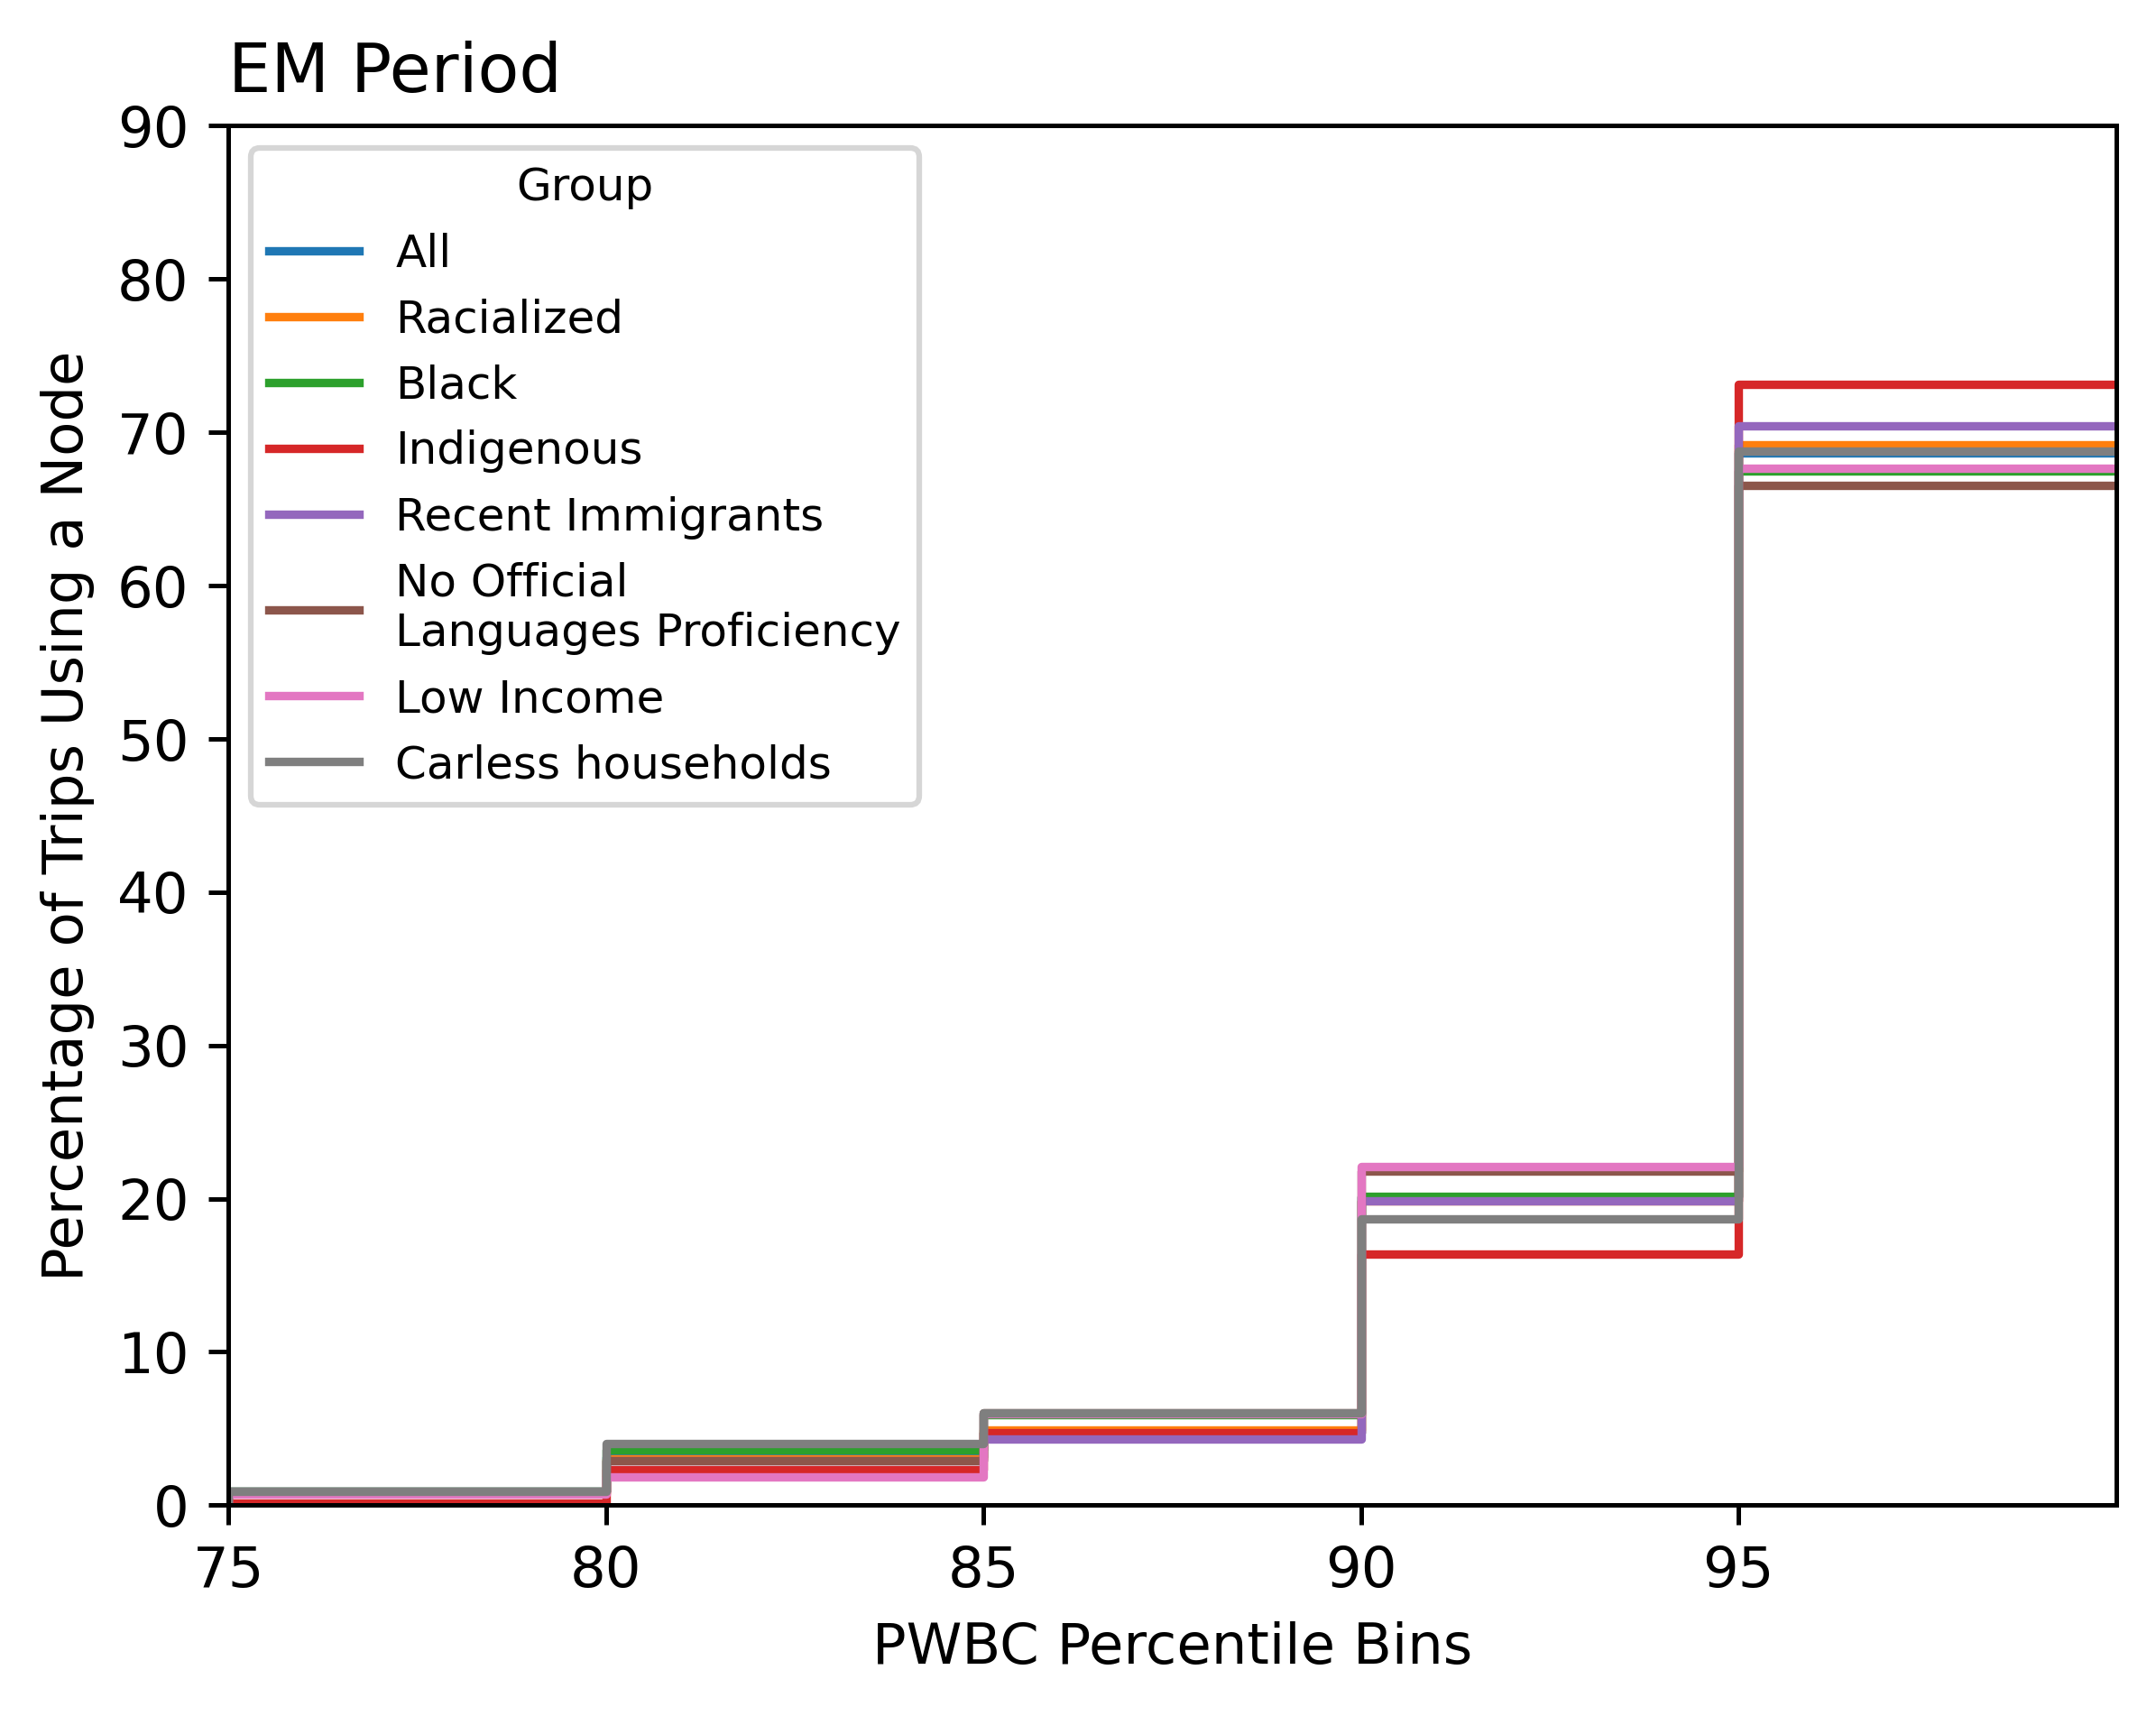

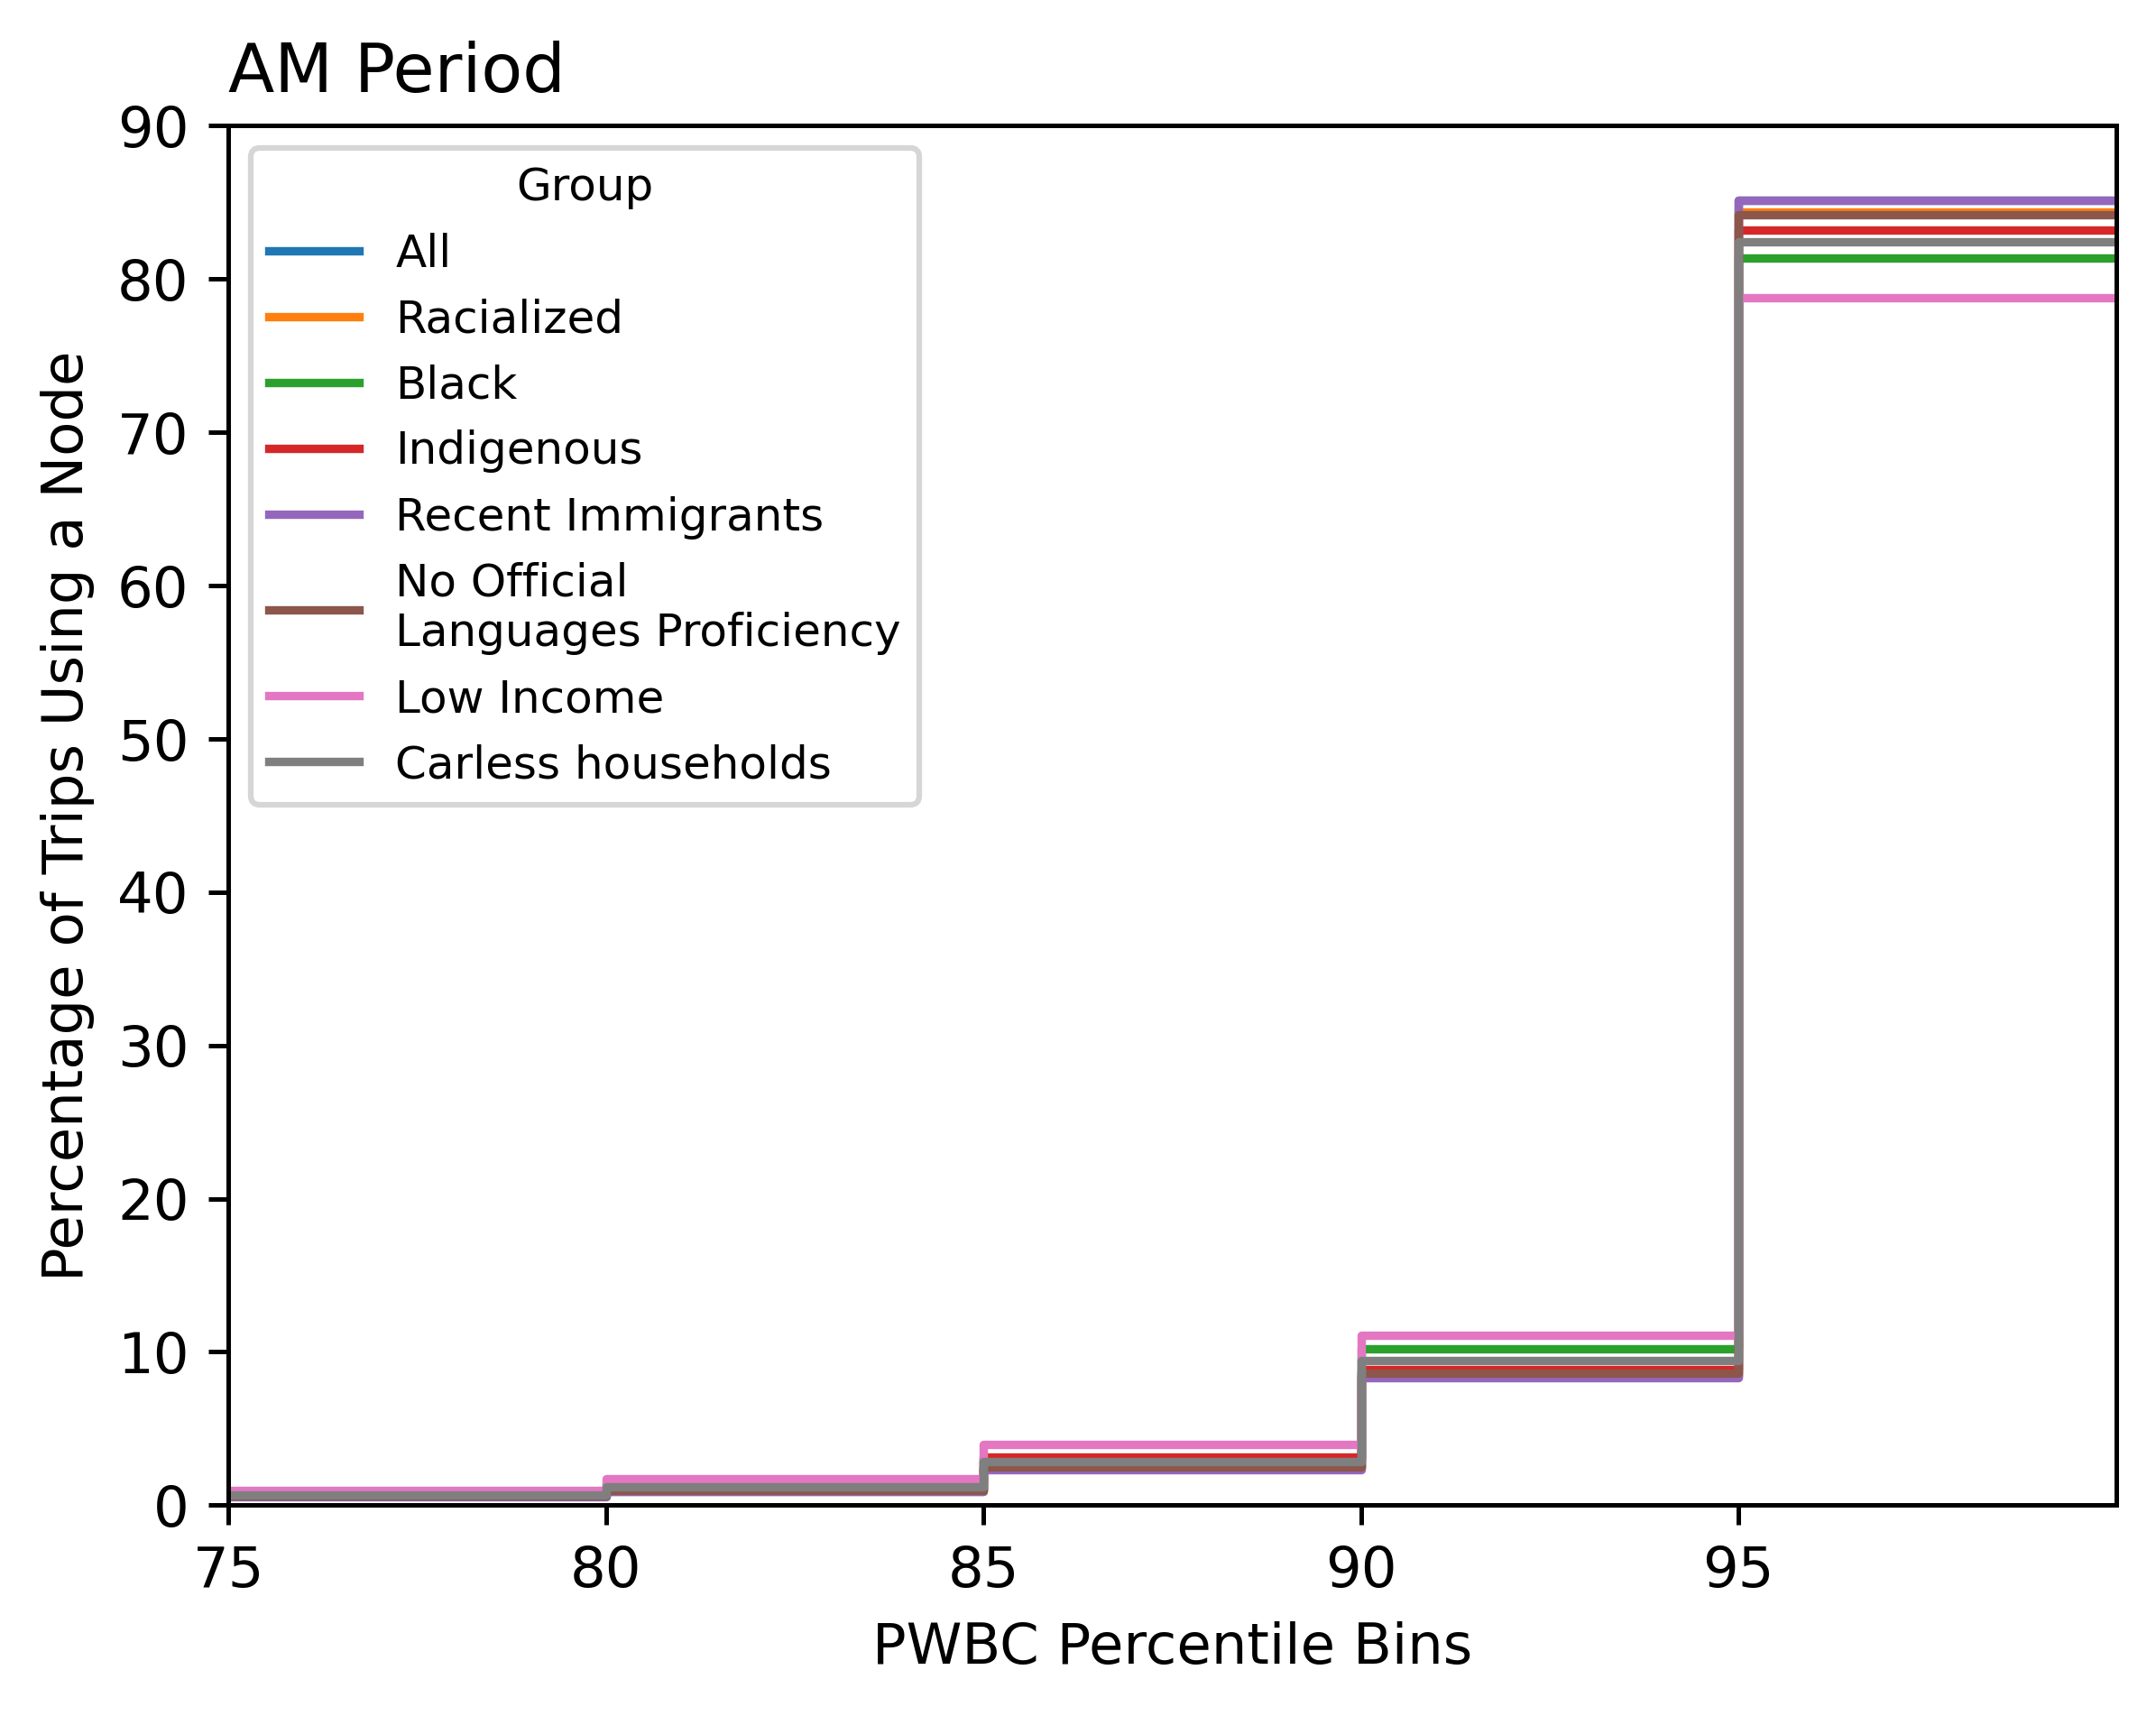

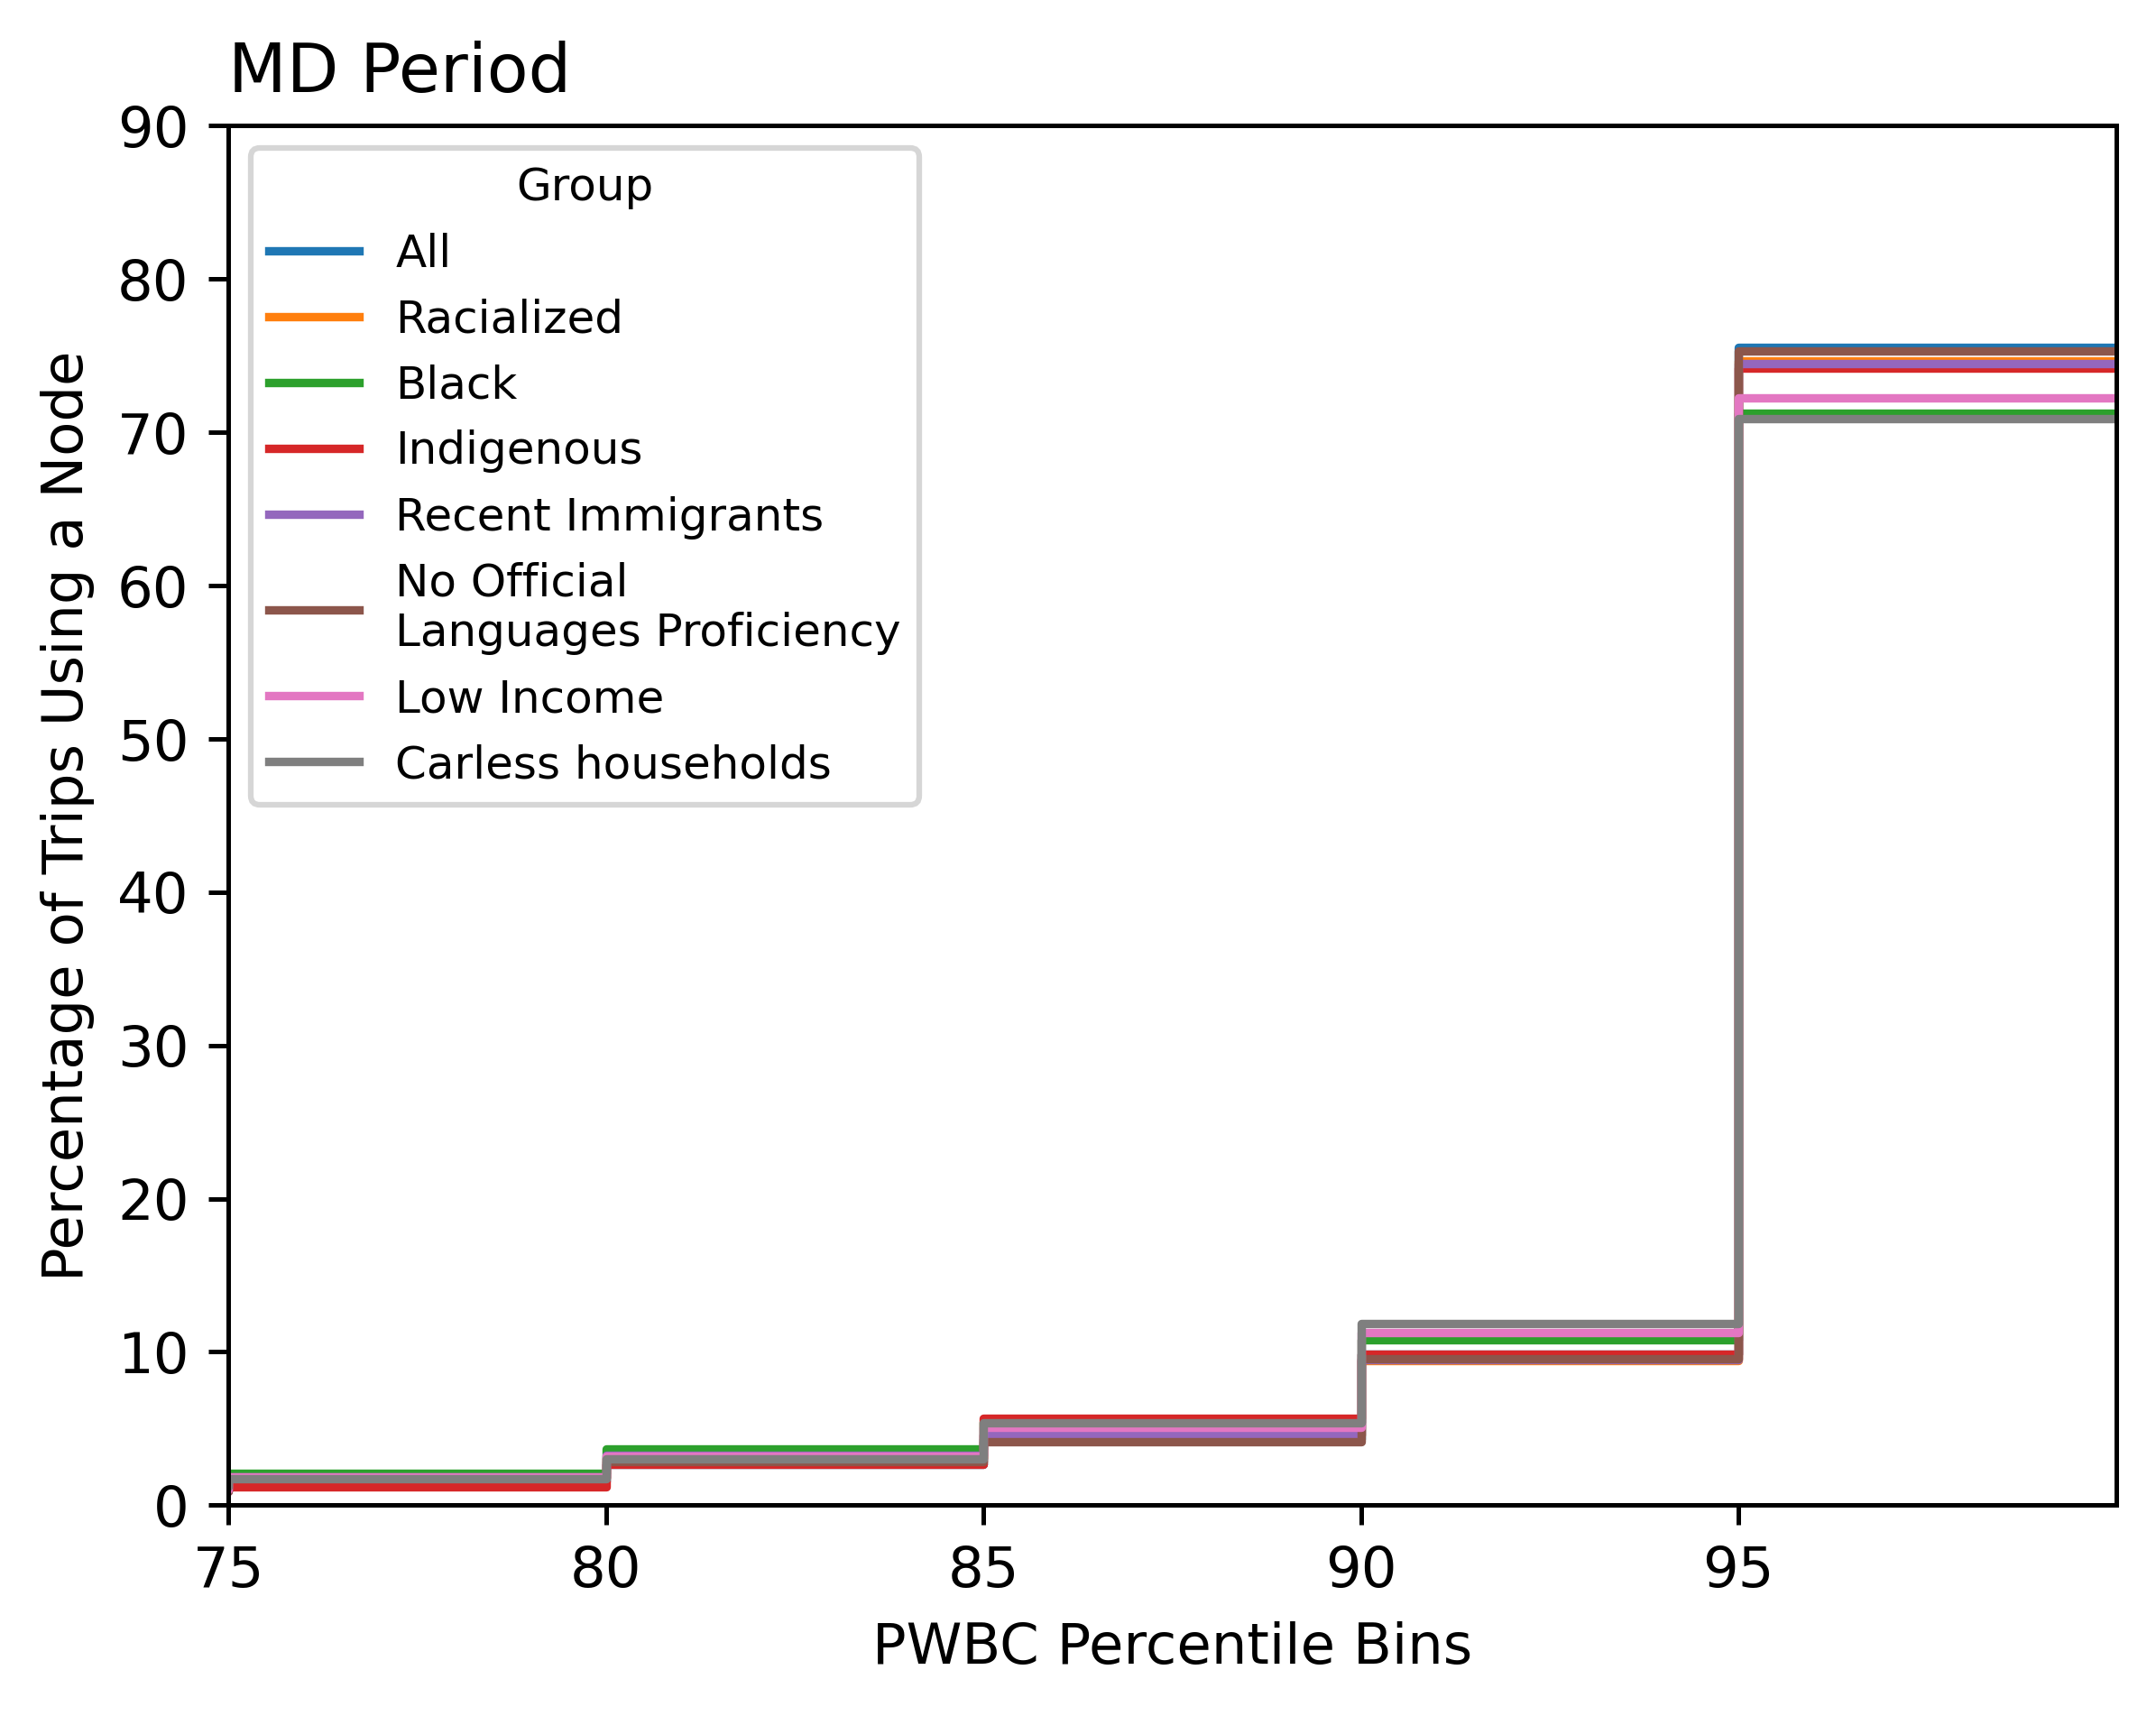

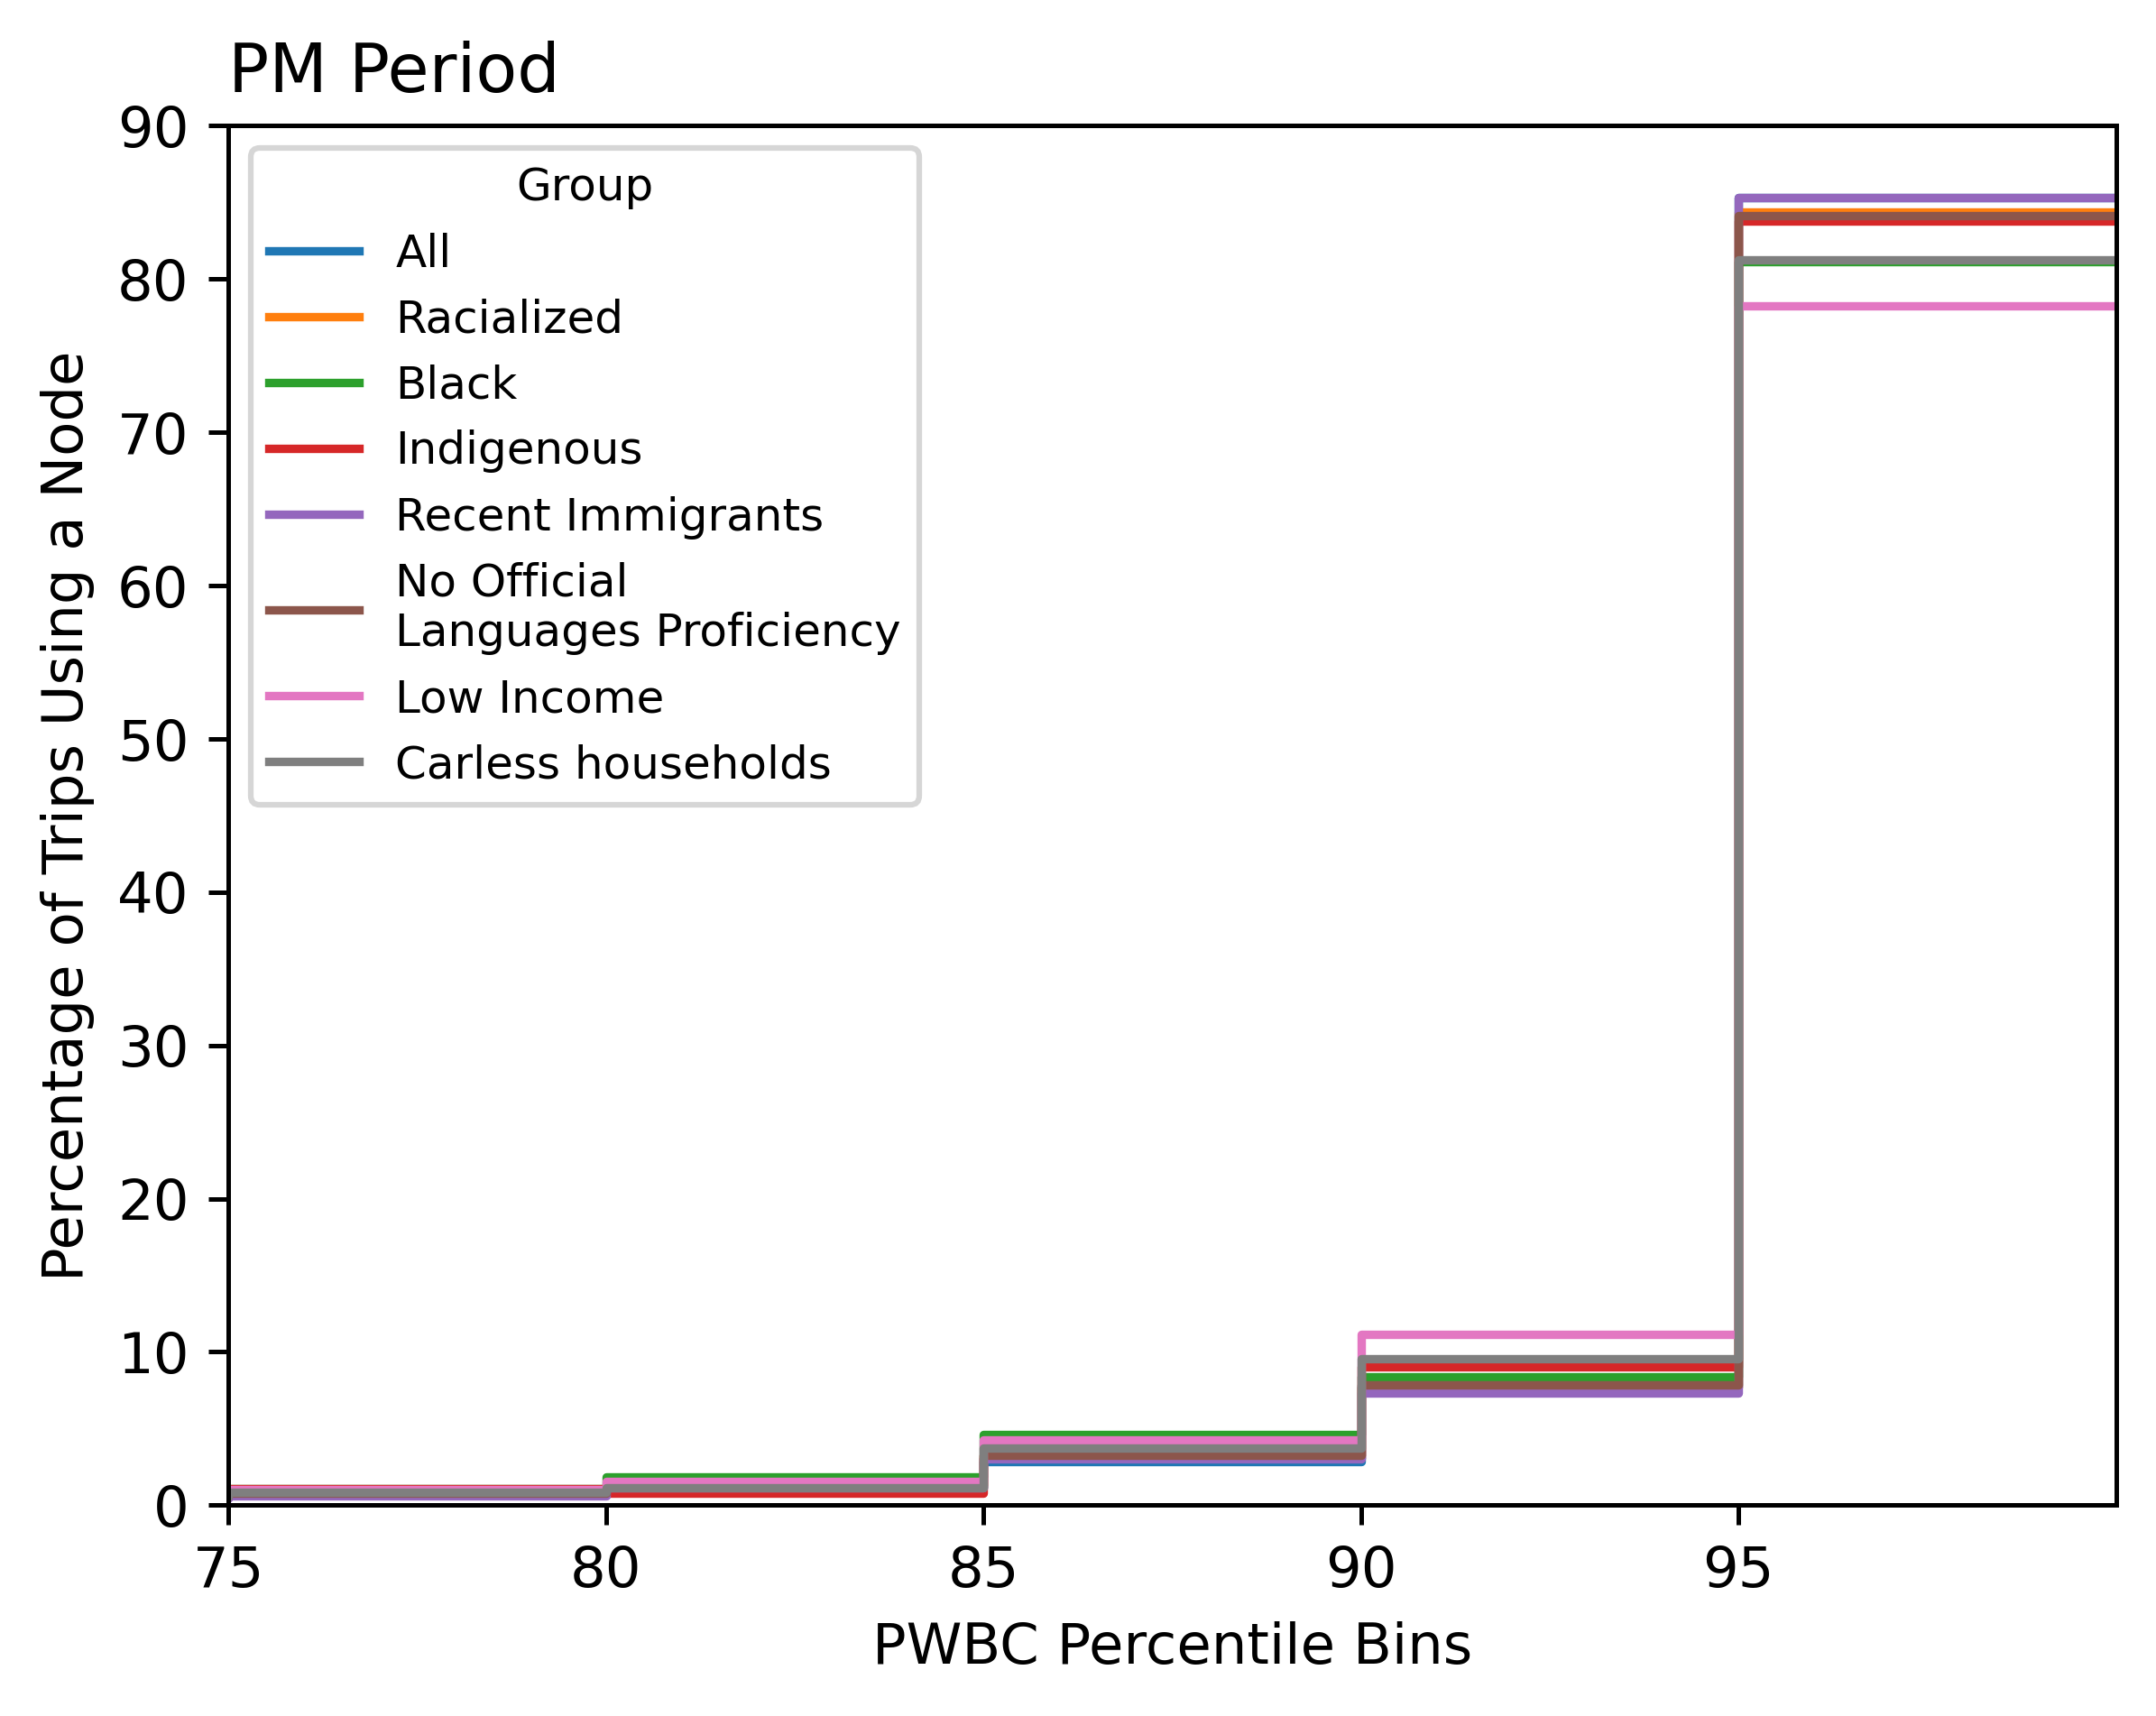

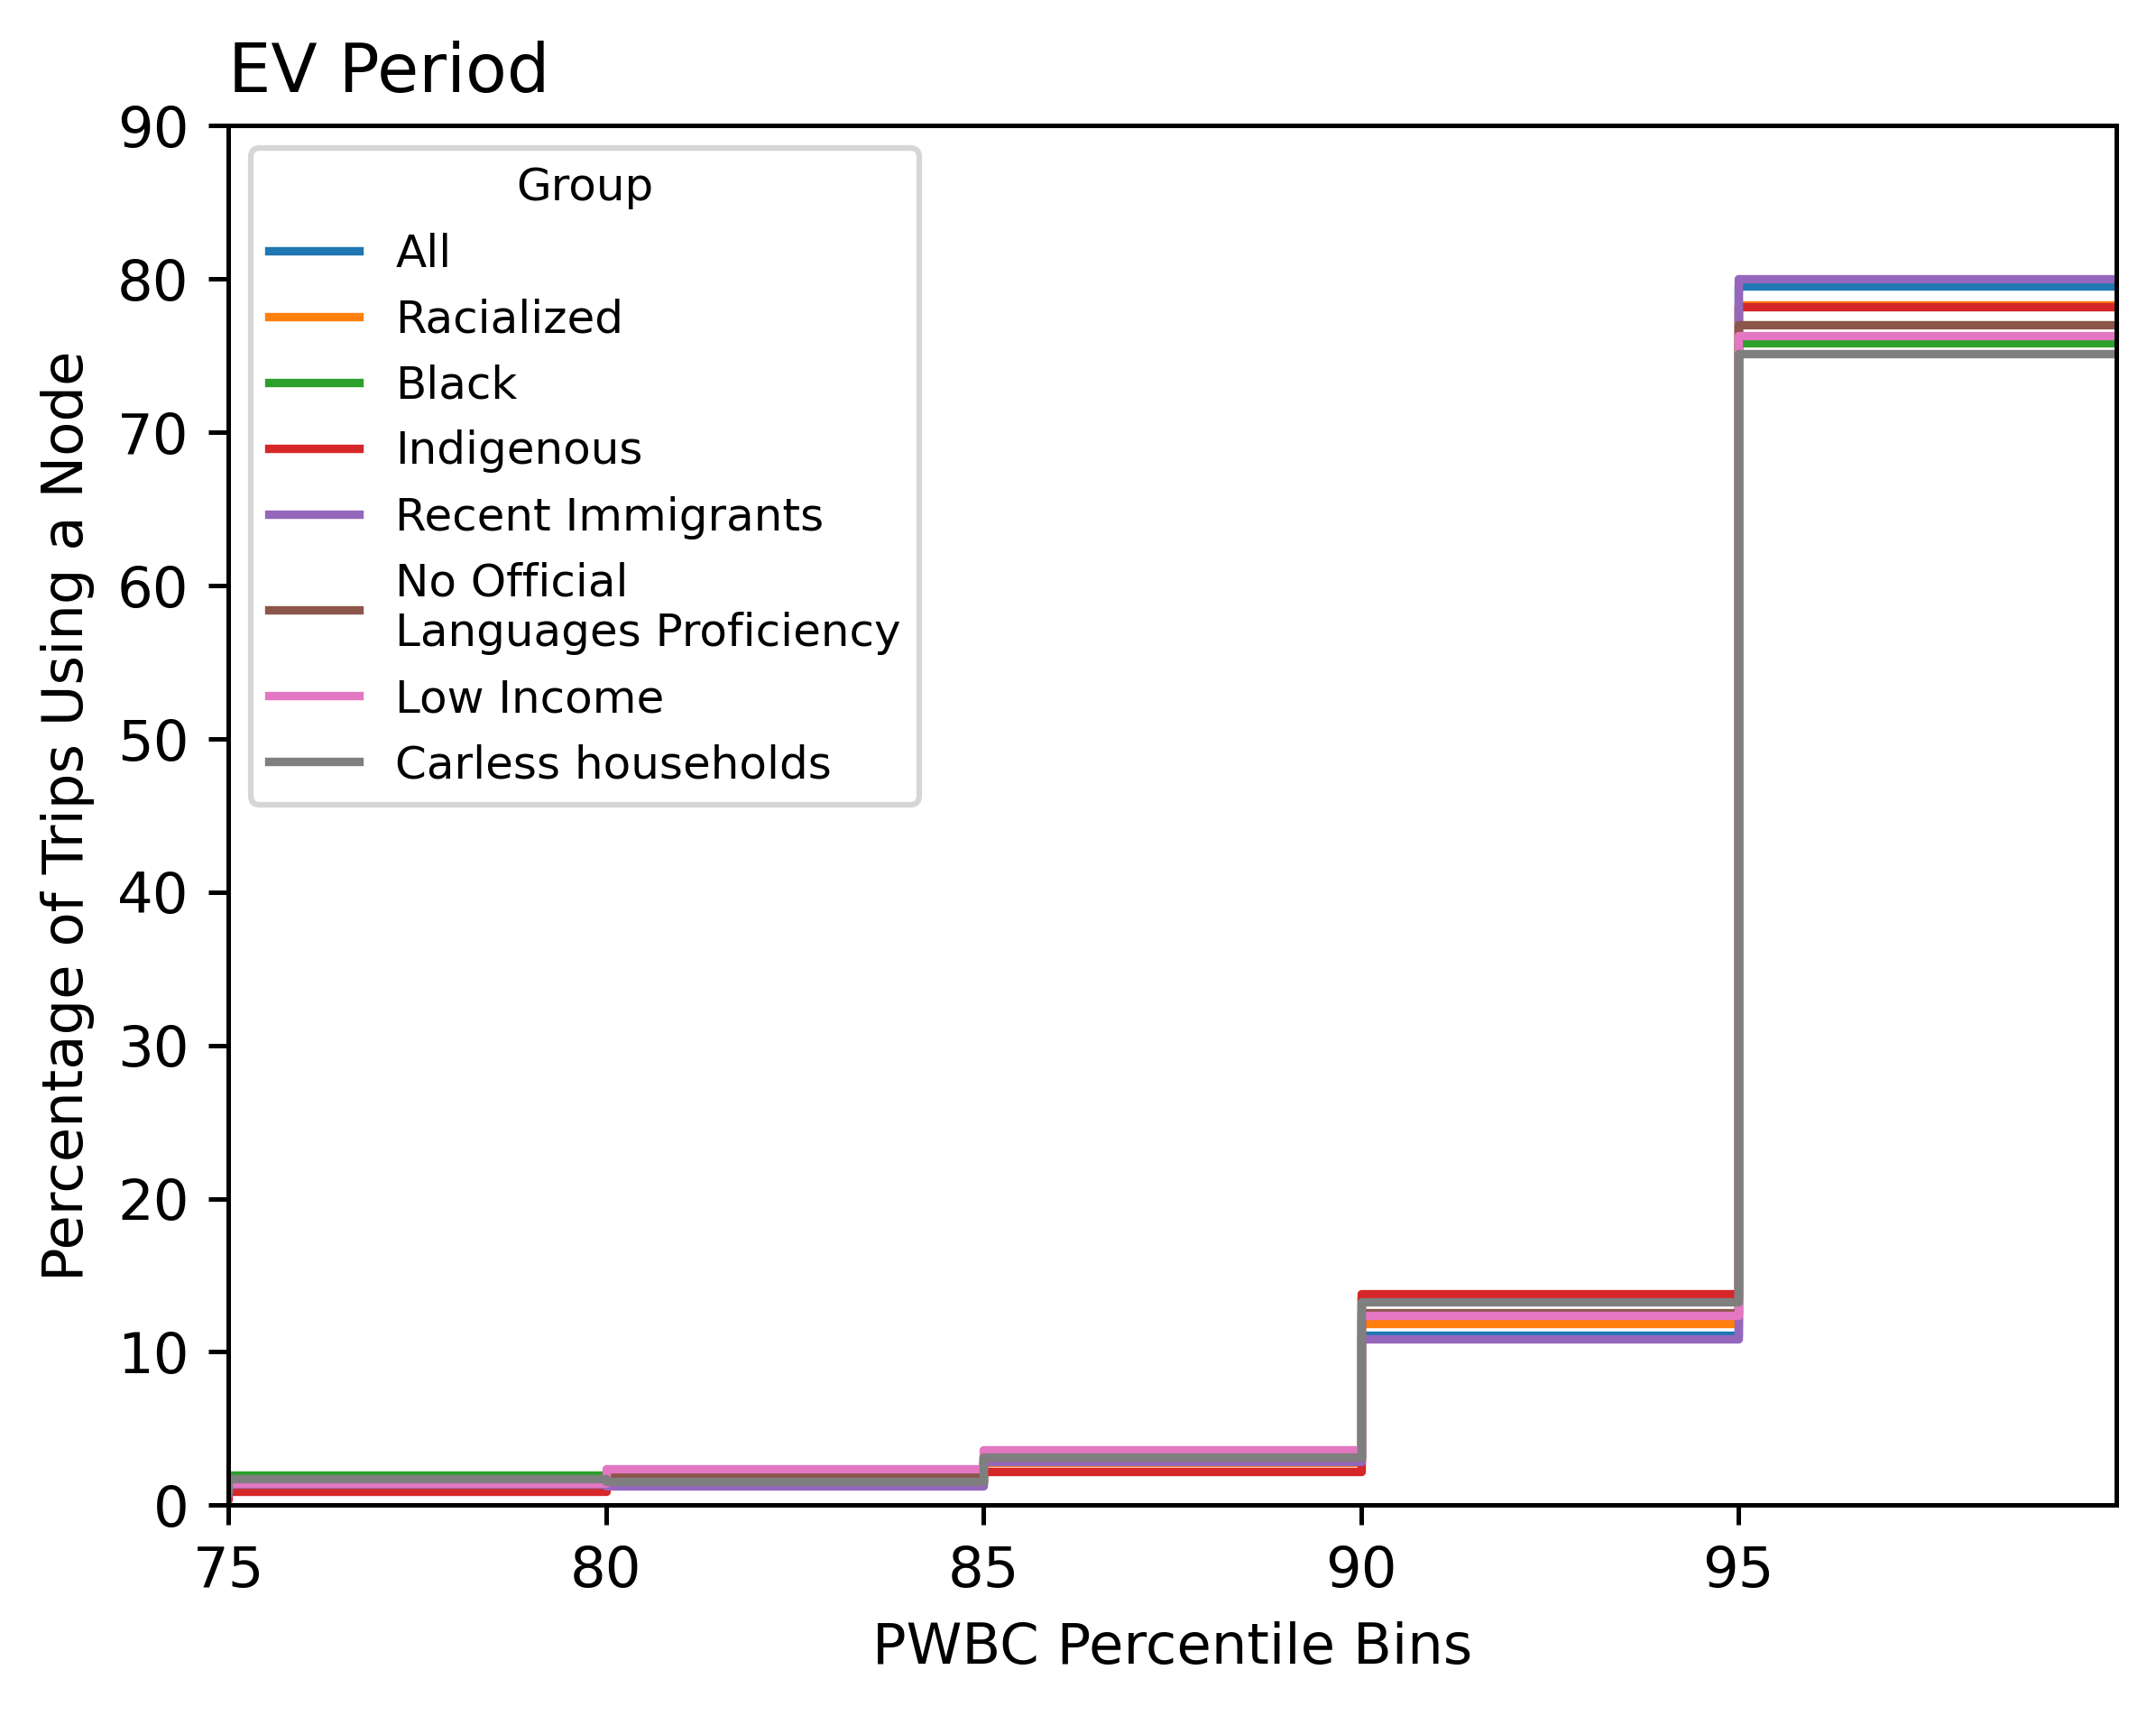

In [82]:
for period in ['EM', 'AM', 'MD', 'PM', 'EV']:

    fig, ax = plt.subplots()

    fig.set_size_inches(6,4.5)

    data = quantile_df[quantile_df['period'] == period]

    plt.step(data[data['group']=='raw']['quantile'], data[data['group']=='raw']['perc'], label = 'All', color = cmap(0))
    plt.step(data[data['group']=='rac']['quantile'], data[data['group']=='rac']['perc'], label = 'Racialized', color = cmap(1))
    plt.step(data[data['group']=='bl']['quantile'], data[data['group']=='bl']['perc'], label = 'Black', color = cmap(2))
    plt.step(data[data['group']=='ab']['quantile'], data[data['group']=='ab']['perc'], label = 'Indigenous', color = cmap(3))
    plt.step(data[data['group']=='imm']['quantile'], data[data['group']=='imm']['perc'], label = 'Recent Immigrants', color = cmap(4))
    plt.step(data[data['group']=='lep']['quantile'], data[data['group']=='lep']['perc'], label = 'No Official\nLanguages Proficiency', color = cmap(5))
    plt.step(data[data['group']=='lico']['quantile'], data[data['group']=='lico']['perc'], label = 'Low Income', color = cmap(6))
    plt.step(data[data['group']=='c0']['quantile'], data[data['group']=='c0']['perc'], label = 'Carless households', color = cmap(7))

    ax.set_title(period + ' Period', fontsize = 12, loc = 'left')

    ax.set_xlabel('PWBC Percentile Bins')
    ax.set_ylabel('Percentage of Trips Using a Node')

    ax.legend(title = 'Group', title_fontsize = 8, fontsize = 8)

    ax.set_xticks(range(14,19,1))
    ax.set_xticklabels([75,80,85,90,95])

    ax.set_xlim([14,19])
    ax.set_ylim([0,90])

    plt.show()

In [34]:
quantile_df

,quantile,flow_experienced,type,perc,group,period
0,0,28.258,raw_am,0.013,raw,AM
1,1,80.278,raw_am,0.038,raw,AM
2,2,245.048,raw_am,0.116,raw,AM
3,3,104.667,raw_am,0.049,raw,AM
4,4,106.811,raw_am,0.051,raw,AM
...,...,...,...,...,...,...
15,15,2.142,lep_em,0.880,lep,EM
16,16,6.990,lep_em,2.873,lep,EM
17,17,14.716,lep_em,6.048,lep,EM
18,18,53.038,lep_em,21.796,lep,EM
